<a href="https://colab.research.google.com/github/BryanBradfo/BryanBradfo/blob/main/tp1_part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Practical session n°1**
In part I:
- Learning a perceptron through stochastic gradient descent.
- Multi-layer perceptron.
- Cost function adapted to classification tasks.

In part II:
- Other basic building blocks of deep networks: convolutional layers and non-linearities.
- Analysis of a standard Convolutionnal Neural Network (CNN) trained on imagenet.

Duration: 2 h

**Part I**

This part introduces neural networks through a presentation of the perceptron. It is also an opportunity to familiarize yourself with PyTorch commands. PyTorch is one of the three most widely used libraries for deep learning, along with Keras and TensorFlow (Keras is built on top of Tensorflow).

"Deep learning" is, by definition, the learning of "deep" neural networks through stochastic gradient descent. By "deep," we mean networks composed of a succession of "layers" of neurons.

The basic building blocks that allow us to construct these layers are coded in the torch.nn module.

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import torch
import torch.nn as nn # briques de base pour construire ses NN
torch.manual_seed(1) # pour refaire une expérience (réitabilité et reproductibilité: initiateur de générateur d'aléatoire, apporte du déterminisme)

**A.** First, let's revisit the perceptron. To introduce learning through stochastic gradient descent, we will address a simple binary classification problem.

0
1


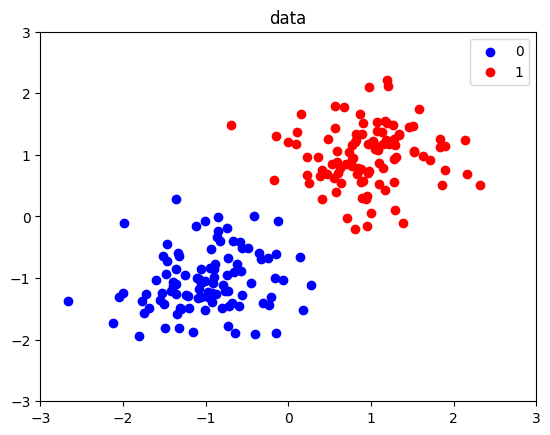

In [ ]:
# Data to separate:
n = 100 # taille de la population
std = 0.5 # écart type, paramètre de la gaussienne

# Sample 1:1er grp
mean0 = torch.tensor((-1., -1.)) # 2 car on veut des points
ech0 = mean0 + std * torch.randn(n, 2) # échantillon associé à ce grp

# Sample 2:2è grp
mean1 = torch.tensor((1., 1.)) # 2 car on veut des points
ech1 = mean1 + std * torch.randn(n, 2) # échantillon associé à ce grp

echs = [ech0, ech1]

# Scatter plot:
fig, ax = plt.subplots()
ax.axis([-3, 3, -3, 3])

plt.title('data')
colors = ['b', 'r']
labels = ['0', '1']

for i, ech in enumerate(echs):
    print(i)
    x, y = ech.numpy()[:, 0], ech.numpy()[:, 1]
    ax.scatter(x, y, color=colors[i])

plt.legend(labels)

A simple perceptron (single neuron) consists of two parts: a linear part containing a dot product and a "bias" (b) and a non-linear part, the activation function (A):
\begin{equation*}
 f(x; \omega,b) = \mathcal{A}({\sum} \omega_i x_i  + b )  \tag{1}
\end{equation*}

(il s'agit d'1 neurone, ici, on a 3 paramètres, les poids font référence biologiquement aux synapses)

The class P1 below codes for perceptrons defined on R^2 and whose activation function is a sigmoid:
\begin{equation*}
\mathcal{A}(y) = \dfrac{1}{1+e^{-y}}
\end{equation*}
The sigmoid function is in the range [0, 1]. Therefore, the neuron's output can be interpreted as the probability of belonging to the first of the two classes. In the P1 class, the neuron actually returns a vector of "probabilities":

In [ ]:
class P1(nn.Module): #nn.Module class qu'on hérite

    # le plus haut niveau de protection : __
    # constructeur
    def __init__(self):
        super(P1, self).__init__() # superclass, appeler le constructeur du superclass
        # self, c'est pour avoir une instance, fc est un attribut crée qui est à cet objet là
        self.fc = nn.Linear(2, 1) # un seul neurone, signaux de dimension 2 en entrée et en sortie 1, parti linéaire (wx+b)

    # méthode de class parcequ'il y a self
    def forward(self, x): # prends en entrée un point
        # Dot product and bias
        x = self.fc(x) #produit scalaire + biais
        # Activation
        x = x.sigmoid()
        # Vector of "probabilities" (cat: concatenation)
        x = torch.cat((x, 1 - x), dim=1) #concatener la fonction sigmoid à 1-x pour avoir la proba d'appartenance de chaque
        return x


    # s'il n'y a pas self, alors c'est méthode statique

model = P1()
print(model)

P1(
  (fc): Linear(in_features=2, out_features=1, bias=True)
)


In the next cell, basic commands are given to access the weights of an instance of P1:

In [ ]:
# Initialization (fantasy) of weights:
model.fc.weight[0, 0].data.fill_(-0.1) #choisir les valeurs de paramèters, w_0 = -0.1
model.fc.weight[0, 1].data.fill_(0.5) #choisir les valeurs de paramèters, w_1 = 0.5
model.fc.bias.data.fill_(-1) #same for biais

# Retrieving weights:
fc = model.fc
weights = fc.weight.data.squeeze(dim=0)
bias = fc.bias.data

print(weights)
print(bias)

tensor([-0.1000,  0.5000])
tensor([-1.])


**Exercise 1**: Verify on an example that $f_c(x) = \sum \omega_i x_i  + b$

In [ ]:
# YOUR CODE HERE

x0 = echs[0][0]
print(x0.T)
print(np.dot(weights,x0.T)+bias)
print(fc(x0))
#raise NotImplementedError()

tensor([-1.7628, -1.3751])
tensor([-1.5113])
tensor([-1.5113], grad_fn=<ViewBackward0>)


<ipython-input-5-d540981ddcd4>:4: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3614.)
  print(x0.T)


To complete the definition of the perceptron, a decision rule is needed. This rule is natural: for $f(x; \omega, b) = (p_0, p_1)$, we choose class 0 if $p_0 > p_1$.

We can plot the boundary that delimits the model's decision regions.

**Exercise 2:**
- Provide its equation in the form $x_1 = \alpha x_0 + \beta$ where $\alpha$ and $\beta$ depend on $\omega$ and $b$.

$$\frac{1}{2} = A(x_0w_0 + x_1w_1+b)$$

$$\Leftrightarrow 0 = x_0w_0 + x_1w_1+b$$

$$\Leftrightarrow x_1 = (-\frac{w_0}{w_1}x_0 - \frac{b}{w_1})$$
- Complete the code below to plot it:

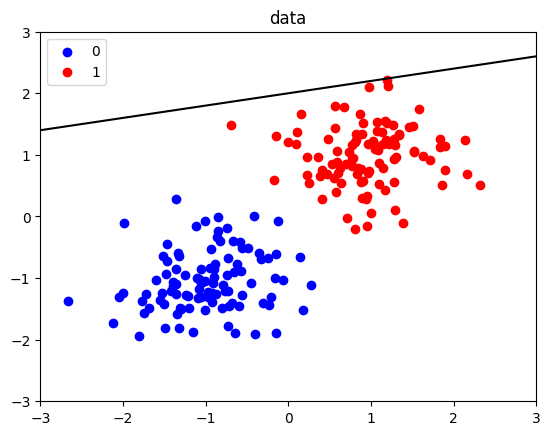

In [ ]:
def traceFrontiere(weights, bias, ax, interval=[-10, 10], color='black'):
    x0 = np.arange(interval[0], interval[1], 0.01) # liste d'abscisses de points de cette frontière
    x1 = (-weights[0]/weights[1])*x0 - (bias/weights[1])
    # YOUR CODE HERE

    #raise NotImplementedError()
    ax.plot(x0, x1, color=color)

traceFrontiere(weights.numpy(), bias.numpy(), ax)

fig


# normal d'avoir ce résultat car pas entrainé

To train the perceptron to correctly separate the classes, we will use stochastic gradient descent with mini-batches. For this, we need to present the model with (*input*, *target*) pairs in a **random** order. In PyTorch, this selection is done using two objects:
- A *Dataset* class
- A *Dataloader* class

A PyTorch Dataset contains a method for accessing data. The following class provides a rudimentary example. Later on, we will integrate data loading, normalization, and data augmentation steps into our datasets:

In [ ]:
from torch.utils.data import Dataset, DataLoader # 2 class

# ex de class Dataset
class FirstDataset(Dataset):

    # comment je la construis? affectation de deux attributs des inputs
    #(points d'entrées d'un ensemble d'entraînement) et des cibles (les classes)
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    # taille de la dataset
    def __len__(self):
        return self.targets.shape[0] #taille = nb de cibles

    # comment on va piocher un élément dans notre population
    def __getitem__(self, idx):  # idx is an index called by the loader
        x = self.inputs[idx, :] #à p. d'un nb entier idx, choisir l'élément numéro par cet index
        t = self.targets[idx] # et choisir la cible numéroté par cet indice
        return x, t  # (input, target) pair

inputs_train = torch.cat(echs, dim=0)
targets_train = torch.cat((torch.zeros(n), torch.ones(n)), dim=0).long()
ds1 = FirstDataset(inputs_train, targets_train)

A **loader** is a Python iterable (like lists, dictionaries, etc.) that we parameterize by batch size and data selection method (with or without replacement, weighting, etc). In particular, with the shuffle = True option, the data is reshuffled at every epoch and num_workers represents how many subprocesses to use for data loading, 0 means that the data will be loaded in the main process (generally interesting to anticipate data loading, to speed up training):

In [ ]:
loader1 = DataLoader(ds1, batch_size=10, shuffle=True,num_workers=0) # j'instancie dataloader à partir
# du Dataset ds1,
# batch_size : nb d'individus pour l'entraînement
# au hasard pck shuffle=True, on les prend sans remise
# num_workers=nb de processus affecté à cette tache d'extraction de données
# num_workers important car getitem prend beaucoup de temps, lance des processeurs pour préparer le getitem en meme temps que le batch s'exécute

In the following figure, we represent a first randomly drawn batch of points. Each time the window is executed, a new batch of points is drawn until exhaustion:

In [ ]:
# premier batch selectionné au hasard

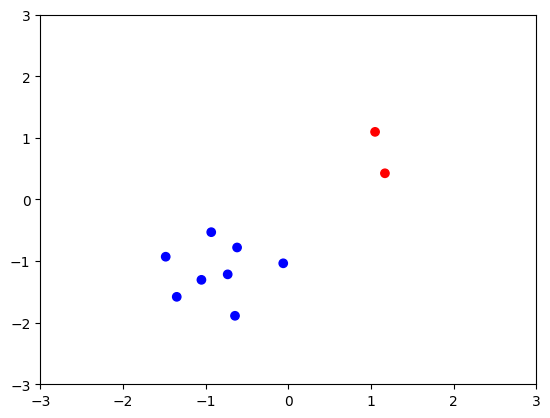

In [ ]:
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2.axis([-3, 3, -3, 3])

# Drawing a batch of ten points
inputs, targets = next(iter(loader1))
x, y = inputs.numpy()[:, 0], inputs.numpy()[:, 1]
cs = [colors[targets[i]] for i in range(len(targets))]
ax2.scatter(x, y, color=cs)

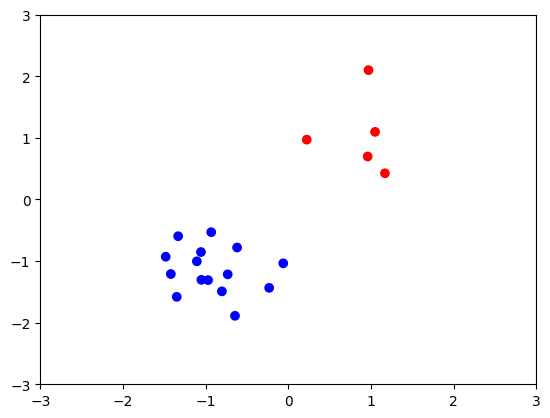

In [ ]:
# On peut répéter cela (relance le code plusieurs fois)
# Iterating over the dataset
inputs, targets = next(iter(loader1))
x, y = inputs.numpy()[:, 0], inputs.numpy()[:, 1]
cs = [colors[targets[i]] for i in range(len(targets))]
ax2.scatter(x, y, color=cs)
fig2

# On va voir les erreurs batch par batch

For each available batch, we calculate the model's error using a loss function. This loss function penalizes the differences between the network's outputs (here, pairs $(p_0, p_1)$) and the ground truth (here, a class $c \in \{ 0 ; 1 \}$).

In classification, we generally use the negative log likelihood. For a batch point, it is defined as:

$\mathcal{L}((p_0, p_1), c) = - ln(p_c)$

This quantity is averaged over each batch:

In [ ]:
# batch comme puissance de 2

# fonction de loss
# c : vérité terrain
def loss_fn(outputs, targets, show=False):
    # all -log(p)
    outputs = -torch.log(outputs)
    # all -log(pc)
    tensor_of_losses = torch.gather(outputs, 1, targets.unsqueeze(dim=1))
    # average of -log(pc)
    loss = tensor_of_losses.mean()

    if show:
        print(outputs)
        print(targets)
        print(tensor_of_losses)

    return loss

Example:

In [ ]:
inputs, targets = next(iter(loader1))
l = loss_fn(model(inputs), targets, show=True)

print(l)

tensor([[1.3305, 0.3070],
        [1.8630, 0.1687],
        [1.5820, 0.2301],
        [1.0200, 0.4472],
        [1.0351, 0.4388],
        [1.3741, 0.2918],
        [1.6713, 0.2083],
        [1.1084, 0.4006],
        [0.8478, 0.5592],
        [1.1074, 0.4011]], grad_fn=<NegBackward0>)
tensor([0, 0, 0, 1, 1, 0, 0, 1, 1, 1])
tensor([[1.3305],
        [1.8630],
        [1.5820],
        [0.4472],
        [0.4388],
        [1.3741],
        [1.6713],
        [0.4006],
        [0.5592],
        [0.4011]], grad_fn=<GatherBackward0>)
tensor(1.0068, grad_fn=<MeanBackward0>)


For each batch, we calculate the derivatives $\dfrac{\partial \mathcal{L_{batch}}}{\partial{\omega_i}}$ where $\mathcal{L_{batch}}$ is the average of the cost function over the batch.

PyTorch keeps track of each operation performed with the weights so that it can apply the usual rules of derivation. This calculation is launched with the *.backward* method. The derivatives are stored with the weights and can be accessed with *.grad*:

In [ ]:
w = model.fc.weight  # [0,0]
print('before backward:' + str(w.grad))

# fait partie de PyTorch, dérivée des fonctions de coût en fonction du paramètre
l.backward()

# ça remplit d'objet poids
print('after backward:' + str(w.grad))

before backward:None
after backward:tensor([[0.5518, 0.5337]])


Last step: updating the weights. For this, many methods are available. We specify the chosen method through the PyTorch "optimizer" object. The simplest is written:

$w_i := w_i - lr \times \dfrac{\partial \mathcal{L_{batch}}}{\partial{\omega_i}}$  (2)

The learning rate ($lr$) controls the amplitude of the increments:

In [ ]:
lr = 0.1

# Two commonly used descent methods:
optimizer = torch.optim.SGD(model.parameters(), lr=lr)  # corresponds to equation (2) (permet de choisir l'update des paramètres)
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In the next cell, we train the perceptron. With each new execution, the dataset is traversed twice (two "epochs"):

0
1


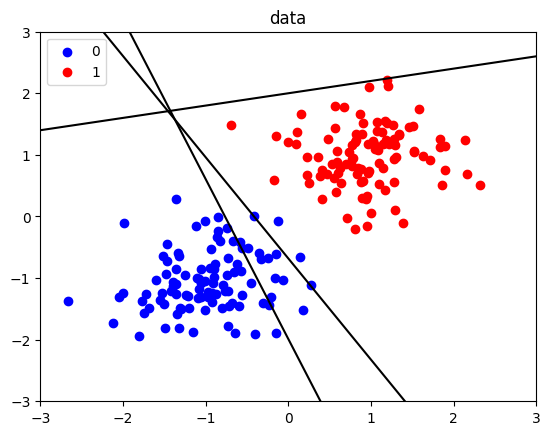

In [ ]:
for epoch in range(2):
    print(epoch)
    # random traversal of the dataset
    for x, targets in loader1:
        # zeroing gradients (pck peut y avoir des valurs résiduels)
        optimizer.zero_grad()
        # calculation of (p0, p1) (calcul les output sur mon batch, x représente le batch)
        output = model(x)
        # calculation of the error
        l = loss_fn(output, targets)
        # calculation of gradients
        l.backward()
        # weight update (j'applique la mise à jour des poids à p. de l'optimizer)
        optimizer.step()

    # Plotting the hyperplane
    fc = model.fc
    weights = fc.weight.data.squeeze(dim=0)
    bias = fc.bias.data
    traceFrontiere(weights.numpy(), bias.numpy(), ax)

fig

**Exercise 3-1**: Complete the following code to plot the gradients in the $\omega_0, \omega_1$ weight space:

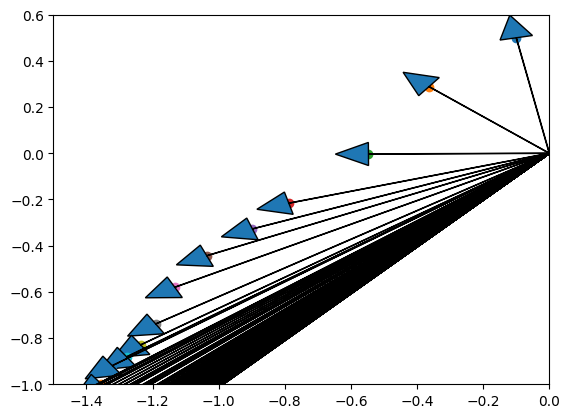

In [ ]:
# Initialization of weights:
model.fc.weight[0, 0].data.fill_(-0.1)
model.fc.weight[0, 1].data.fill_(0.5)
model.fc.bias.data.fill_(-1)

fig3 = plt.figure()
ax3 = fig3.add_subplot(111)
ax3.axis([-1.5, 0, -1, 0.6])

loader1 = DataLoader(ds1, batch_size=10, shuffle=True)
lr = 0.5
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

for epoch in range(25):
    for x, label in loader1:
        optimizer.zero_grad()
        output = model(x)
        l = loss_fn(output, label)
        l.backward()

        # plotting vectors:
        # weights = ...
        # YOUR CODE HERE
        weights = model.fc.weight[0].detach().numpy()
        # raise NotImplementedError()

        # ax3.scatter(...)
        ax3.scatter(weights[0], weights[1])
        # ax3.arrow(...)
        ax3.arrow(0, 0, weights[0], weights[1], head_width=0.1, head_length=0.1)
        # ax3.arrow(0, 0, bias[0], bias[1], head_width=0.1, head_length=0.1)
        # YOUR CODE HERE
        # raise NotImplementedError()
        optimizer.step()

**Exercise 3-2:** Determine the accuracy of the classifier on the training set.

In [ ]:
# Accuracy on the training set:
# YOUR CODE HERE
# raise NotImplementedError()
correct = 0
total = 0
for x, label in loader1:
    output = model(x)
    _, predicted = torch.max(output.data, 1)
    total += label.size(0)
    correct += (predicted == label).sum().item()

acc = correct / total * 100
print(f"Accuracy:{acc:.2f}%")

Accuracy:100.00%


**Note:**

A model of the class *P1* corresponds to a class of statistical models widely used with predictors of small dimensions: logistic regression.

This model is used to **explain and predict** the value of a binary qualitative variable.

Let Z be a random variable with values in {c_1, c_2}.
Logistic regression with respect to the predictor $X = (X_1, X_2, ...)$ is written:

$$ ℙ(Z = c_1 | X ) = \sigma (\sum \omega_i X_i + b ) $$

Where $\sigma$ is the sigmoid function. In the context of logistic regression, the weights $\omega_i$ are obtained by **maximum likelihood**.

**B.** Now, let's consider the question of separating more complex sets of points:

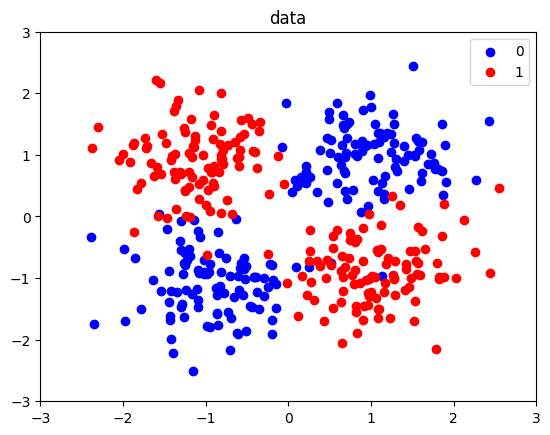

In [ ]:
n = 100
std = 0.5
# sample 0:
meana = torch.tensor((-1., -1.))
echa = meana + std * torch.randn(n, 2)
meanb = torch.tensor((1., 1.))
echb = meanb + std * torch.randn(n, 2)

ech0 = torch.cat([echa, echb])

# sample :
meanc = torch.tensor((1., -1.))
echc = meanc + std * torch.randn(n, 2)
meand = torch.tensor((-1., 1.))
echd = meand + std * torch.randn(n, 2)

ech1 = torch.cat([echc, echd])

echs2 = [ech0, ech1]

# Scatter plot:

plt.figure(0)
plt.axis([-3, 3, -3, 3])

plt.title('data')
colors = ['b', 'r']
labels = ['0', '1']

for i, ech in enumerate(echs2):
    x, y = ech.numpy()[:, 0], ech.numpy()[:, 1]
    plt.scatter(x, y, color=colors[i])

plt.legend(labels)

**Exercise 4:**

What is the approximate best accuracy achievable with a model of class *P1*?

Complete the *P3* class and train a model to achieve an accuracy of at least 90% on the training set.

Why does the score after 50 epochs vary so much with each new training?

Is it possible, with another class of model, to achieve 100% accuracy?

In [ ]:
class P3(nn.Module):

    def __init__(self):
        super(P3, self).__init__()
        self.fc1 = nn.Linear(2, 2)  # first layer: 2 neurons
        self.fc2 = nn.Linear(2, 1)  # second layer: 1 neuron

    def forward(self, x):
        x = self.fc1(x)
        # YOUR CODE HERE
        # raise NotImplementedError()
        x = torch.sigmoid(self.fc2(x))
        x = torch.cat((x, 1 - x), dim=1)  # output of sum 1

        return x

In [ ]:
# dataset
# YOUR CODE HERE
# raise NotImplementedError()
class MyDataset(torch.utils.data.Dataset):

    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index]

# Create the dataset
ds2 = MyDataset(echs2)
loader2 = DataLoader(ds2, batch_size=10, shuffle=True,num_workers=0)

In [ ]:
from tqdm import tqdm # Progess bar
lr = 0.1
model = P3()
# Two commonly used descent methods:
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
#optimizer = torch.optim.Adam(model.parameters(), lr=lr)

for epoch in tqdm(range(100)):
    for x, labels in loader2:
        # YOUR CODE HERE
        #raise NotImplementedError()
        optimizer.zero_grad()
        output = model(x)
        loss = loss_fn(output, labels)
        optimizer.step()

print("\nTraining end")
# accuracy
# YOUR CODE HERE
# raise NotImplementedError()
# Accuracy on the training set:
# YOUR CODE HERE
# raise NotImplementedError()

correct = 0
total = 0
for x, labels in loader2:
    output = model(x)
    _, predicted = torch.max(output.data, 1)
    predicted = predicted.unsqueeze(dim=1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

acc = correct / total * 100
print(f"Accuracy:{acc:.2f}%")


  0%|          | 0/100 [00:00<?, ?it/s]


RuntimeError: ignored

In [ ]:
class P9(nn.Module):

    def __init__(self):
        super(P9, self).__init__()
        self.fc1 = nn.Linear(2,4) # a first layer with 4 neurons
        self.fc2 = nn.Linear(4,4) # a second layer with 4 neurons
        self.fc3 = nn.Linear(4,1) # a third layer with 1 neuron
    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
model = P9()
# YOUR CODE HERE
raise NotImplementedError()
print(f"Accuracy:{acc:.2f}%")

As the complexity of the model increases, the boundaries can better adapt to the **training set**.

**C.** Now let's see how to generalize the approach to multiple classes:

In [ ]:
n = 100
std = 0.5
# Sample 0:
mean0 = torch.tensor((-1., -1.))
ech0 = mean0 + std * torch.randn(n, 2)

# Sample 1:
mean1 = torch.tensor((1., -1.))
ech1 = mean1 + std * torch.randn(n, 2)

# Sample 2:
mean2 = torch.tensor((0., 1.))
ech2 = mean2 + std * torch.randn(n, 2)

echs3 = [ech0, ech1, ech2]

# Scatter plot:
plt.figure(0)
plt.axis([-3, 3, -3, 3])

plt.title('data')
colors = ['b', 'r', 'g']
labels = ['0', '1', '2']

for i, ech in enumerate(echs):
    x, y = ech.numpy()[:, 0], ech.numpy()[:, 1]
    plt.scatter(x, y, color=colors[i])

plt.legend(labels)

To separate these points, a two-layer perceptron should be sufficient. The problem is defining the cost function. To continue using the log-likelihood, the output layer will have as many neurons as classes. To define a probability distribution, normalized exponentials are used (softmax function):

$p_i = \dfrac{e^{y_i}}{\sum{e^{y_j}}}$
  
Where the $y_i$ are the outputs of the neurons in the last layer.

In [ ]:
class P6(nn.Module):

    def __init__(self):
        super(P6, self).__init__()
        self.fc1 = nn.Linear(2, 2)  # First layer: 2 neurons
        self.fc2 = nn.Linear(2, 3)  # Second layer: 3 neurons

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = self.fc1(x)
        x = x.relu()
        x = self.fc2(x)
        x = x.softmax(dim=1)
        return x

**Exercise 5:** Create datasets and dataloaders objects and check if it is possible to separate the points (accuracy > 95%).

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()
print(inputs3.shape)
print(targets3.shape)

In [ ]:
model = P6()
# YOUR CODE HERE
raise NotImplementedError()
print(f"Accuracy:{acc:.2f}%")